['code_comment_count_growth_rate', 'code_comment_deprecated_count_growth_rate', 'code_comment_deprecated_ratio', 'code_comment_explanation_count_growth_rate', 'code_comment_explanation_ratio', 'code_comment_future work_count_growth_rate', 'code_comment_future work_ratio', 'issue_comment_bug report_count_growth_rate', 'issue_comment_bug report_ratio', 'issue_comment_conclusion_count_growth_rate', 'issue_comment_conclusion_ratio', 'issue_comment_count_growth_rate', 'issue_comment_discussion_count_growth_rate', 'issue_comment_discussion_ratio', 'issue_comment_feature request_count_growth_rate', 'issue_comment_feature request_ratio', 'issue_comment_question_count_growth_rate', 'issue_comment_question_ratio', 'issue_comment_solution_count_growth_rate', 'issue_comment_solution_ratio', 'positivity_ratio', 'star_count_end', 'star_count_start', 'star_growth_rate']


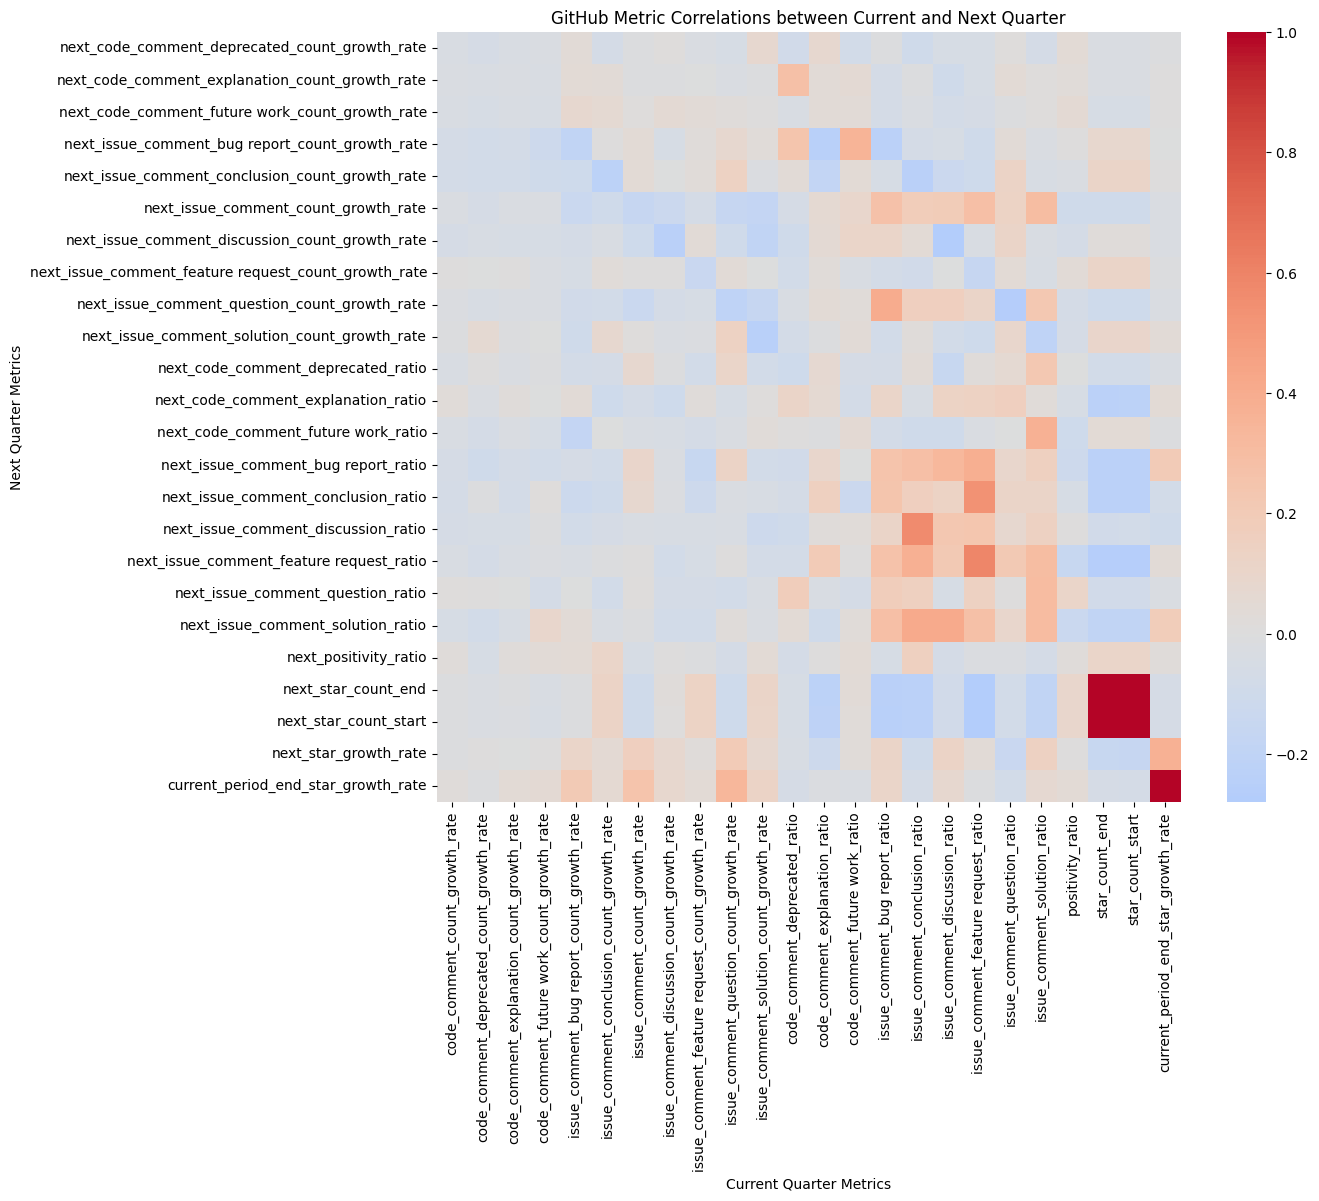

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

timeframe = "quarterly"

data = pd.read_csv(f'./{timeframe}_repo_metrics.csv')

# Extract the relevant columns (numeric ones) for correlation analysis
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
# drop anything with "Unnamed" in the name
numeric_columns = [col for col in numeric_columns if 'Unnamed' not in col]
print(numeric_columns)

# Shift the numeric columns to get the next quarter's data for each row
for col in numeric_columns:
    data[f'next_{col}'] = data.groupby('Unnamed: 1')[col].shift(-1)

# sort columns to make it easier to read
sorter = lambda col: ('star' in col, col.endswith('_count'), col.endswith('_ratio'), col.endswith('_growth_rate'), col)
numeric_columns = sorted(numeric_columns, key=sorter)

# Drop rows where the next quarter's data is NaN (end of the sequence for each repo)
extended_data = data.dropna(subset=[f'next_{col}' for col in numeric_columns], how='all')

# Select only the columns needed for correlation (current and next quarter's metrics)
correlation_data = extended_data[[*[x for x in numeric_columns if x != 'star_growth_rate'], *sorted([*map(lambda col: f'next_{col}', numeric_columns), 'star_growth_rate'], key=sorter)]]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Extract the correlations between this quarter's and next quarter's metrics
correlation_matrix_next = correlation_matrix.loc[numeric_columns, correlation_data.columns[len(numeric_columns):]]

heatmap_data = correlation_matrix_next.loc[numeric_columns, correlation_matrix_next.columns]
# rename 'star_growth_rate' to 'current_star_growth_rate' for clarity
heatmap_data.rename(columns={'star_growth_rate': 'current_period_end_star_growth_rate'}, index={'star_growth_rate': 'current_period_end_star_growth_rate'}, inplace=True)

# Switch the axes for the heatmap by transposing the data
# and save image to disk
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data.T, cmap='coolwarm', center=0)
plt.title('GitHub Metric Correlations between Current and Next Quarter')
plt.xlabel('Current Quarter Metrics')
plt.ylabel('Next Quarter Metrics')
plt.savefig(f'{timeframe}_correlation_heatmap_FINAL.png', dpi=300, bbox_inches='tight')
plt.show()


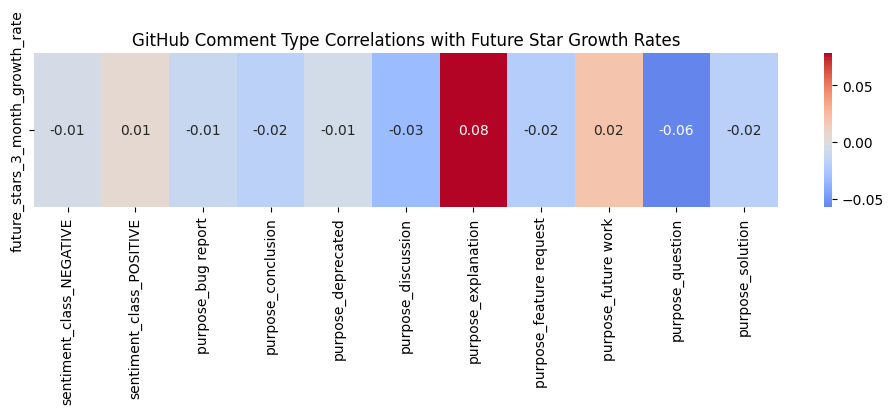

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('github_comments_with_future_stars.csv')

# Generate dummy variables for categorical columns
class_columns = pd.get_dummies(data[['sentiment_class', 'purpose']], drop_first=False).astype(int)
# Select columns ending with '_growth_rate' as numeric columns
numeric_columns = data[[col for col in data.columns if col.endswith('3_month_growth_rate')]] # all are pretty much the same

# Combine class and numeric columns
all_columns = class_columns.join(numeric_columns)

# Replace infinite values with NaN and drop rows where all numeric columns are NaN
extended_data = all_columns.replace([float('inf'), -float('inf')], float('nan'))
extended_data = extended_data.dropna(subset=[col for col in numeric_columns.columns], how='all')

# Ensure we are using the correct columns for correlation
correlation_data = extended_data[class_columns.columns.tolist() + numeric_columns.columns.tolist()]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Extract the part of the correlation matrix that relates class columns to numeric columns
correlation_matrix_next = correlation_matrix.loc[class_columns.columns, numeric_columns.columns]

# Rename 'star_growth_rate' to 'current_star_growth_rate' for clarity, if such a column exists
if 'star_growth_rate' in correlation_matrix_next.columns:
    correlation_matrix_next = correlation_matrix_next.rename(columns={'star_growth_rate': 'current_period_end_star_growth_rate'}, 
                                                             index={'star_growth_rate': 'current_period_end_star_growth_rate'})

# Transpose the data for the heatmap to switch the axes
heatmap_data = correlation_matrix_next.T

plt.figure(figsize=(12, 2))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('GitHub Comment Type Correlations with Future Star Growth Rates')
plt.savefig('individual_comment_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\joshm\AppData\Local\Temp\ipykernel_16712\3687977822.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  grouped_data = data.groupby(pd.Grouper(freq='Q'))['sentiment_class'].value_counts(normalize=True).unstack(fill_value=0)


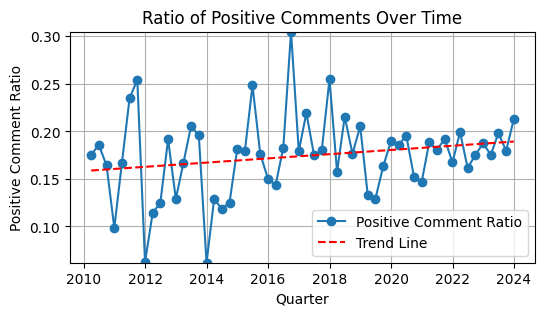

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your data
data = pd.read_csv('github_comments_with_future_stars.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Group by quarter with ratio of positive to total comments
grouped_data = data.groupby(pd.Grouper(freq='Q'))['sentiment_class'].value_counts(normalize=True).unstack(fill_value=0)
grouped_data['positive_ratio'] = grouped_data.get('POSITIVE', 0)

# Prepare the figure
plt.figure(figsize=(6, 3))

# Plot the original data
plt.plot(grouped_data['positive_ratio'], marker='o', label='Positive Comment Ratio')

# Fit the trend line (1st degree polynomial)
x_numeric = np.arange(len(grouped_data.index))
y = grouped_data['positive_ratio']
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)

# Generate x values (same as original data points) for the trend line
x_trend = np.arange(len(grouped_data.index))

# Plot the trend line
plt.plot(grouped_data.index, p(x_trend), "r--", label='Trend Line')

# Check and possibly adjust the y-axis limits
plt.ylim(min(min(y), min(p(x_trend))), max(max(y), max(p(x_trend))))

plt.title('Ratio of Positive Comments Over Time')
plt.xlabel('Quarter')
plt.ylabel('Positive Comment Ratio')
plt.grid(True)
plt.legend()

plt.savefig('positive_comment_ratio_over_time_with_trend.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\joshm\AppData\Local\Temp\ipykernel_16712\1388934807.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  grouped_data = filtered_data.groupby([pd.Grouper(freq='Q'), 'purpose'])['purpose'].count().unstack(fill_value=0)


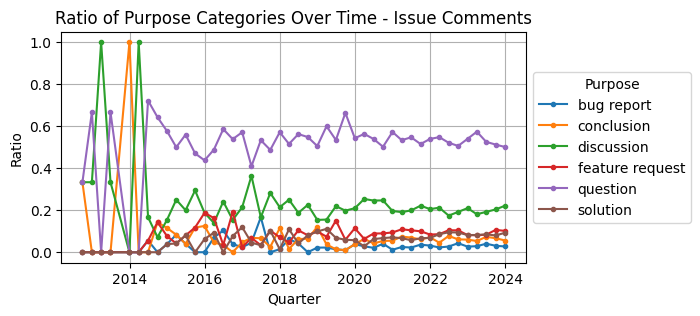

C:\Users\joshm\AppData\Local\Temp\ipykernel_16712\1388934807.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  grouped_data = filtered_data.groupby([pd.Grouper(freq='Q'), 'purpose'])['purpose'].count().unstack(fill_value=0)


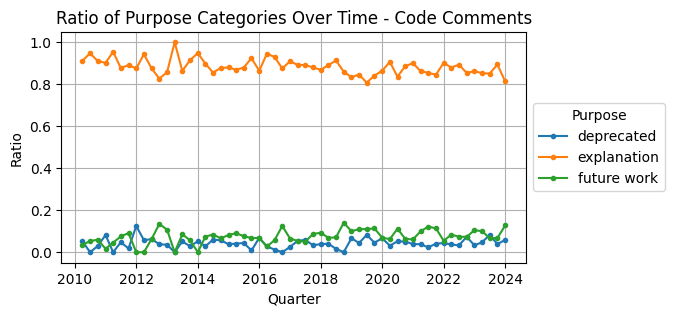

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('github_comments_with_future_stars.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Function to plot the ratio of 'purpose' categories over time
def plot_purpose_ratio(filtered_data, title):
    grouped_data = filtered_data.groupby([pd.Grouper(freq='Q'), 'purpose'])['purpose'].count().unstack(fill_value=0)
    total_counts = grouped_data.sum(axis=1)
    purpose_ratio = grouped_data.divide(total_counts, axis=0)

    plt.figure(figsize=(6, 3))
    for column in purpose_ratio.columns:
        plt.plot(purpose_ratio.index, purpose_ratio[column], marker='o', label=column, markersize=3)

    plt.title(title)
    plt.xlabel('Quarter')
    plt.ylabel('Ratio')
    plt.legend(title='Purpose', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

# Filter data for 'issue' and 'code' types
issue_data = data[data['type'].str.contains('issue')]
code_data = data[data['type'].str.contains('code')]

# Plot for each type
plot_purpose_ratio(issue_data, 'Ratio of Purpose Categories Over Time - Issue Comments')
plot_purpose_ratio(code_data, 'Ratio of Purpose Categories Over Time - Code Comments')


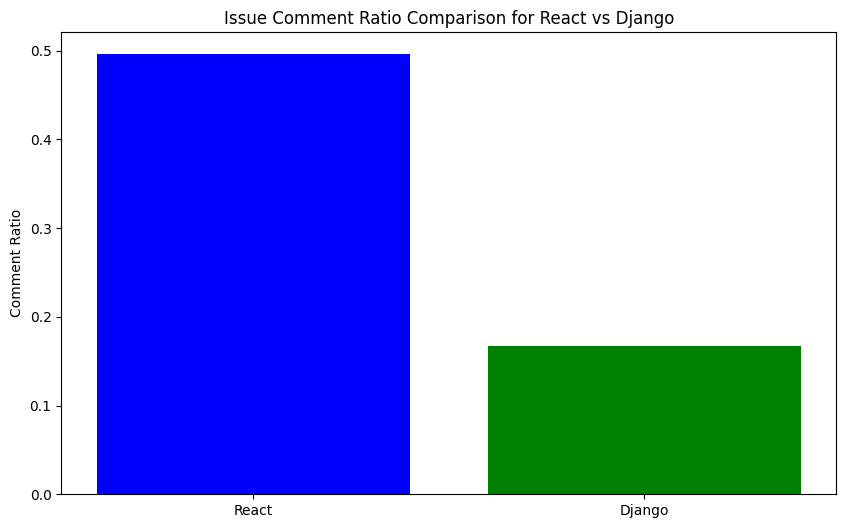

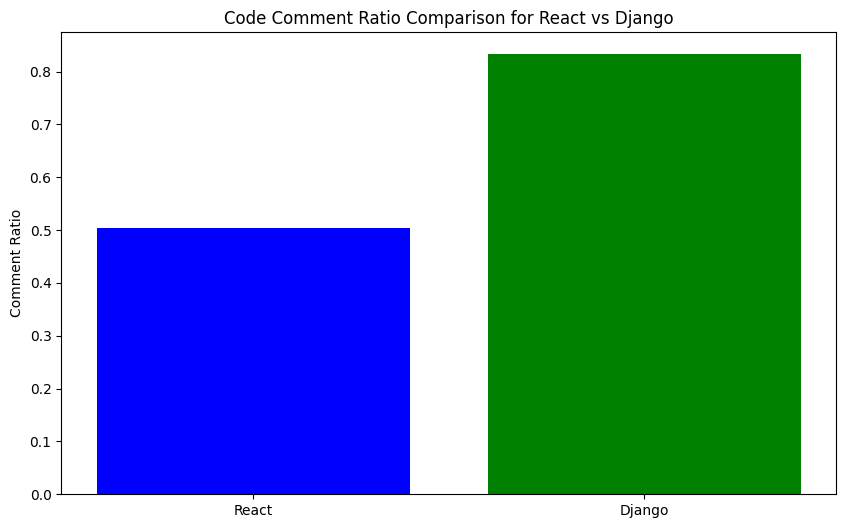

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('github_comments_with_future_stars.csv')

# Filter data for 'react' and 'django' repositories
react_data = data[data['repo'].str.contains('react')]
django_data = data[data['repo'].str.contains('django')]

# Function to calculate and plot comment ratios
def plot_comment_ratio(react_data, django_data, comment_type, title):
    # Calculate the ratio of the specified comment type
    react_ratio = react_data[react_data['type'].str.contains(comment_type)]['type'].count() / len(react_data)
    django_ratio = django_data[django_data['type'].str.contains(comment_type)]['type'].count() / len(django_data)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(['React', 'Django'], [react_ratio, django_ratio], color=['blue', 'green'])
    plt.title(title)
    plt.ylabel('Comment Ratio')
    plt.show()

# Plot for 'issue' comments
plot_comment_ratio(react_data, django_data, 'issue', 'Issue Comment Ratio Comparison for React vs Django')

# Plot for 'code' comments
plot_comment_ratio(react_data, django_data, 'code', 'Code Comment Ratio Comparison for React vs Django')


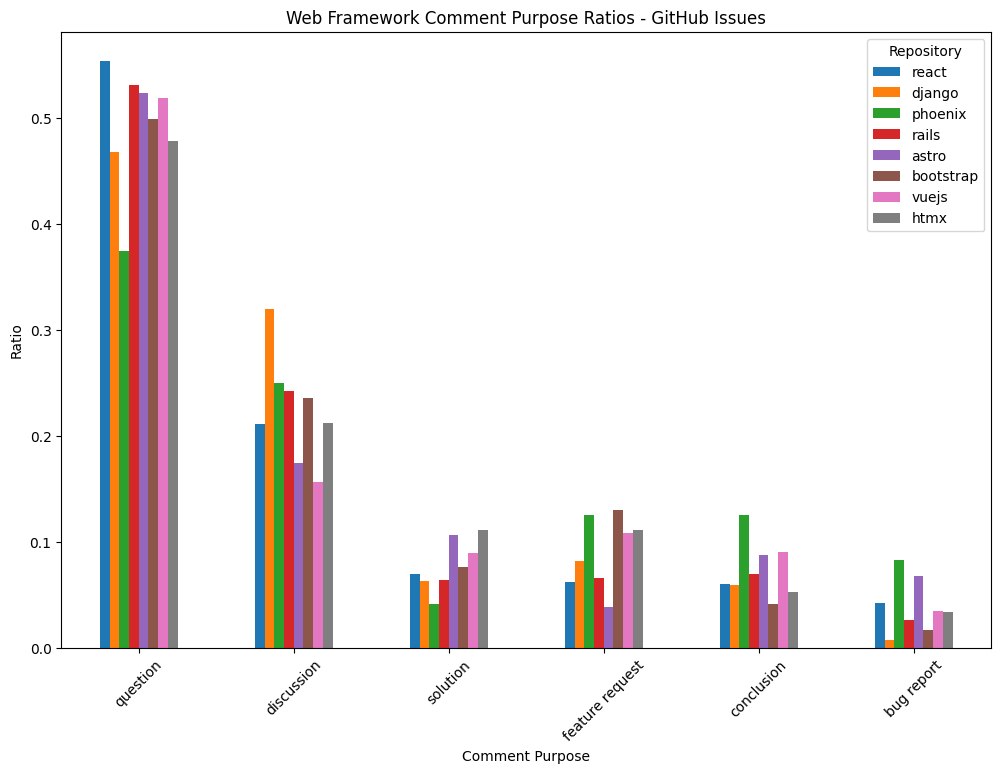

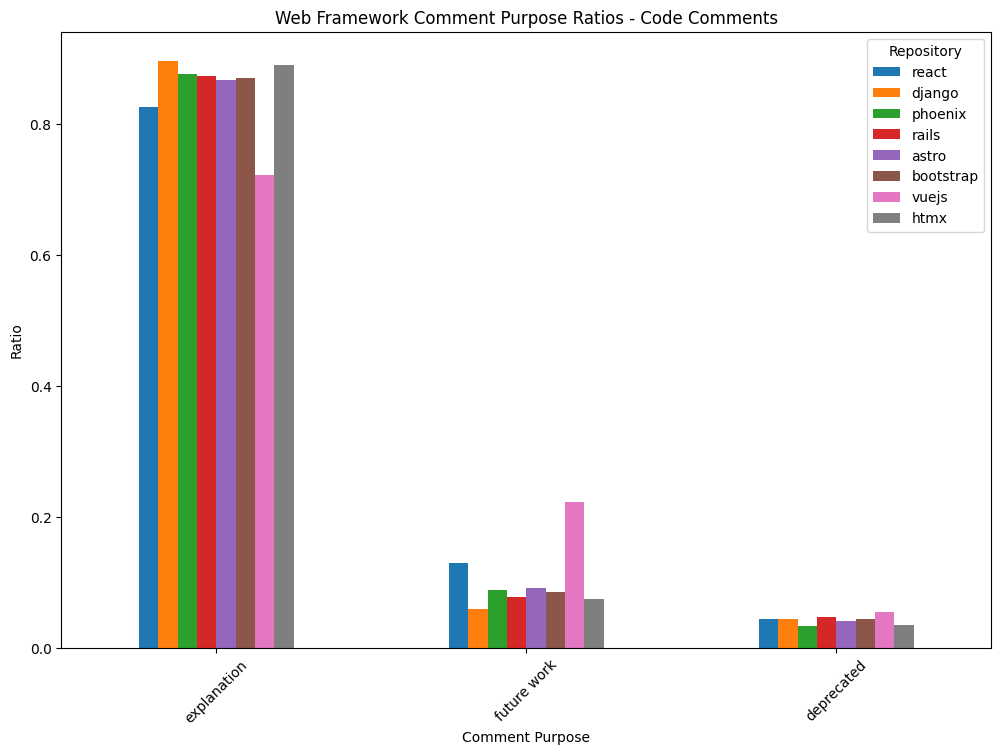

                 react  django  phoenix  rails  astro  bootstrap  vuejs  htmx
purpose                                                                      
question           788     126        9    700     54        585    698   254
discussion         301      86        6    320     18        276    211   113
solution            99      17        1     84     11         90    120    59
feature request     88      22        3     87      4        153    146    59
conclusion          86      16        3     92      9         48    122    28
bug report          60       2        2     34      7         20     47    18
Chi-square statistic: 176.24809190126996
p-value: 9.512753726103207e-21
There is a statistically significant difference between the groups.
             react  django  phoenix  rails  astro  bootstrap  vuejs  htmx
purpose                                                                  
explanation   1195    1200     1316   1209   1276       1298     78   866
future work   

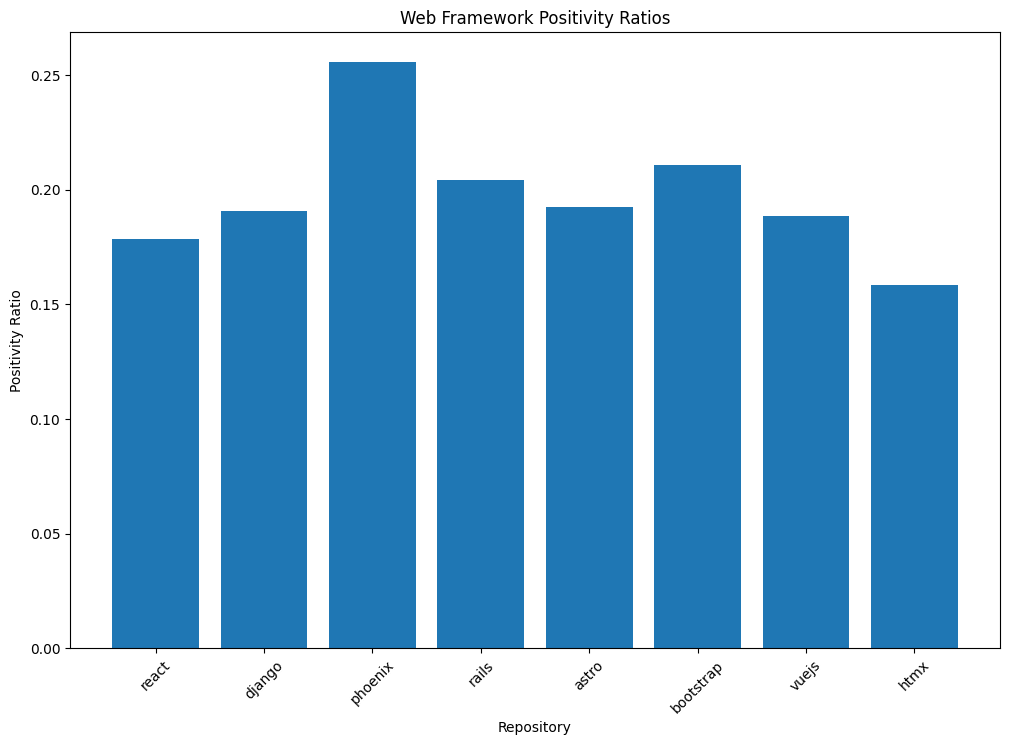

Chi-square statistic for positivity: 59.09529156921819
p-value for positivity: 2.2875454384357164e-10
There is a statistically significant difference between the groups for positivity.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Load the data
data = pd.read_csv('github_comments_with_future_stars.csv')

def plot_purpose_ratio_for_repos(data, repos, comment_type, title):
    # Initialize a DataFrame to hold the purpose ratios for all repositories
    all_ratios = pd.DataFrame()

    for repo in repos:
        # Filter data for the specific repo and comment type
        repo_data = data[data['repo'].str.contains(repo, case=False) & data['type'].str.contains(comment_type, case=False)]
        purpose_ratio = repo_data['purpose'].value_counts(normalize=True)
        all_ratios[repo] = purpose_ratio

    # Plotting
    all_ratios = all_ratios.fillna(0)  # Fill NaN with 0
    all_ratios.plot(kind='bar', figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Ratio')
    plt.xlabel('Comment Purpose')
    plt.xticks(rotation=45)
    plt.legend(title='Repository')
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_positivity_ratio(data, repos, title):
    positivity_ratios = {}

    for repo in repos:
        repo_data = data[data['repo'].str.contains(repo, case=False)]
        positive_count = repo_data[repo_data['sentiment_class'] == 'POSITIVE'].shape[0]
        total_count = repo_data.shape[0]
        positivity_ratios[repo] = positive_count / total_count if total_count > 0 else 0

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(positivity_ratios.keys(), positivity_ratios.values())
    plt.title(title)
    plt.ylabel('Positivity Ratio')
    plt.xlabel('Repository')
    plt.xticks(rotation=45)
    plt.savefig(title + '.png', dpi=300, bbox_inches='tight')
    plt.show()

def test_positivity_significance(data, repos):
    positivity_counts = pd.DataFrame()

    for repo in repos:
        repo_data = data[data['repo'].str.contains(repo, case=False)]
        counts = repo_data['sentiment_class'].value_counts()
        positivity_counts[repo] = counts

    positivity_counts = positivity_counts.fillna(0)
    chi2, p, dof, expected = chi2_contingency(positivity_counts.T)

    print("Chi-square statistic for positivity:", chi2)
    print("p-value for positivity:", p)

    if p < 0.05:
        print("There is a statistically significant difference between the groups for positivity.")
    else:
        print("There is no statistically significant difference between the groups for positivity.")

# Repositories list
repos = ['react', 'django', 'phoenix', 'rails', 'astro', 'bootstrap', 'vuejs', 'htmx']

# Plotting and testing purpose ratios
plot_purpose_ratio_for_repos(data, repos, 'issue', 'Web Framework Comment Purpose Ratios - GitHub Issues')
plot_purpose_ratio_for_repos(data, repos, 'code', 'Web Framework Comment Purpose Ratios - Code Comments')
test_statistical_significance(data, repos, 'issue')
test_statistical_significance(data, repos, 'code')

# Plotting and testing positivity ratios
plot_positivity_ratio(data, repos, 'Web Framework Positivity Ratios')
test_positivity_significance(data, repos)
